In [94]:
import numpy as np
from qiskit import QuantumCircuit

In [95]:
import numpy as np

def generate_unicycle_ldpc(m, n):
    """
    Generate a unicycle LDPC code.
    Parameters:
        m: Number of rows (check bits).
        n: Number of columns (code bits).
    Returns:
        Hx, Hz: LDPC parity-check matrices for X and Z errors.
    """
    H = np.random.randint(0, 2, (m, n))
    Hx = H
    Hz = H[:, ::-1]  # Reverse the columns for unicycle codes
    return Hx, Hz

def rand_bin_array(K, N):
    arr = np.zeros(N)
    arr[:K]  = 1
    np.random.shuffle(arr)
    return arr

def cyclic_shift_matrix(arr):
    N = len(arr)
    matrix = np.zeros((N, N), dtype=arr.dtype)  # Create a matrix of size N x N
    for i in range(N):
        matrix[i] = np.roll(arr, i)  # Shift the array by i positions
    return matrix

def generate_bicycle_ldpc_1(n, m, k):
    n_sub = int(n/2)
    row = rand_bin_array(k, n_sub)
    c = cyclic_shift_matrix(row)
    return np.concatenate((c, c.T), axis=1)

In [96]:
###THESE WORK.
Hx = np.array([[1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0],
               [1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0],
               [0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1],
               [1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0],
               [0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1],
               [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1]])

Hz = np.array([[1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0],
               [1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0],
               [0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1],
               [1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0],
               [0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1],
               [0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1]])

# USE BICYCLE PARITY CHECK MATRICES
#Hx = generate_bicycle_ldpc_1(12, 3, 3)
#Hz = Hx


# # 验证自正交性质 (HxHz^T = 0 mod 2)
check_orthogonality = np.mod(np.dot(Hx, Hz.T), 2)


zeros = np.zeros(Hx.shape)

rank = np.linalg.matrix_rank(Hx)

print(Hx)
print(Hz)
print(check_orthogonality)
print(rank)

[[1 0 0 1 0 1 1 1 0 1 0 0]
 [1 1 0 0 1 0 0 1 1 0 1 0]
 [0 1 1 0 0 1 0 0 1 1 0 1]
 [1 0 1 1 0 0 1 0 0 1 1 0]
 [0 1 0 1 1 0 0 1 0 0 1 1]
 [0 0 1 0 1 1 1 0 1 0 0 1]]
[[1 0 0 1 0 1 1 1 0 1 0 0]
 [1 1 0 0 1 0 0 1 1 0 1 0]
 [0 1 1 0 0 1 0 0 1 1 0 1]
 [1 0 1 1 0 0 1 0 0 1 1 0]
 [0 1 0 1 1 0 0 1 0 0 1 1]
 [0 0 1 0 1 1 1 0 1 0 0 1]]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]
6


In [97]:
H0 = np.concatenate((np.concatenate((Hx, zeros), axis=1), np.concatenate((zeros, Hz), axis=1))) #in the standard form for a CSS code

In [98]:
def get_stabilizers(H_sub, stab):
    all_stab = []
    for n in range(len(H_sub)):
        curr_str = ''
        row = H_sub[n]
        for m in row:
            if m:
                curr_str += stab
            else:
                curr_str += 'I'
        print(curr_str)
        all_stab.append(curr_str)
    return all_stab

In [99]:
get_stabilizers(Hx, 'X')

XIIXIXXXIXII
XXIIXIIXXIXI
IXXIIXIIXXIX
XIXXIIXIIXXI
IXIXXIIXIIXX
IIXIXXXIXIIX


['XIIXIXXXIXII',
 'XXIIXIIXXIXI',
 'IXXIIXIIXXIX',
 'XIXXIIXIIXXI',
 'IXIXXIIXIIXX',
 'IIXIXXXIXIIX']

In [100]:
def make_stabilizer_circ(Hx, Hz, noise_inject=None, input_qc=None):
    """
    Generate a stabilizer circuit given Hx and Hz.
    noise_inject: a list of functions which take in a qc and with probability p, adds a single pauli to each qubit.
    ^The functions in noise_inject are shown in below example, and require error prob and number of data qubits
    as input (so the ancillas will not have errors).

    """
    if input_qc:
        data = input_qc.qregs[0]
        ancilla = input_qc.qregs[1]

    qc = QuantumCircuit(Hx.shape[1] + Hx.shape[0] + Hz.shape[0], Hx.shape[0] + Hz.shape[0])
    x_offset = Hx.shape[1]
    z_offset = Hx.shape[1] + Hx.shape[0]

    for i in range(len(Hx)):
        row  = Hx[i]
        #print(row)
        for j in range(len(row)):
            curr = row[j]
            #print(curr)
            if curr:
                #print(i, j, curr)
                qc.cx(j, i + x_offset) #need to track offset
                print("Added X stabilizer from qubit " + str(j) + " to ancilla " + str(i))
                qc.barrier()

    for i in range(len(Hz)):
        row  = Hz[i]
        #print(row)
        for j in range(len(row)):
            curr = row[j]
            #print(curr)
            if curr:
                #print(i, j, curr)
                qc.cz(j, i + z_offset) #need to track offset
                print("Added Z stabilizer from qubit " + str(j) + " to ancilla " + str(i))
                qc.barrier()

    #log where errors were added
    logs = []
    for f in noise_inject:
        log = None
        logs.append(log)
    #qc.x(10)
    qc.measure(range(Hx.shape[1], Hx.shape[1] + Hx.shape[0] + Hz.shape[0]), range(Hx.shape[0] + Hz.shape[0]))
    if input_qc:
        qc = input_qc.append(qc)
    if noise_inject:
        return qc, logs
    else:
        return qc

In [101]:
def make_stabilizer_circ_1(Hx, Hz,  qc, noise_inject=None):
    """
    Generate a stabilizer circuit given Hx and Hz.
    noise_inject: a list of functions which take in a qc and with probability p, adds a single pauli to each qubit.
    ^The functions in noise_inject are shown in below example, and require error prob and number of data qubits
    as input (so the ancillas will not have errors).

    """
    qc.barrier()
    data = qc.qregs[0]
    ancilla = qc.qregs[1]

    x_offset = 0
    z_offset = Hx.shape[0]

    for i in range(len(Hx)):
        row  = Hx[i]
        #print(row)
        for j in range(len(row)):
            curr = row[j]
            #print(curr)
            if curr:
                #print(i, j, curr)
                qc.cx(data[j], ancilla[i]) #need to track offset
                print(j, i)
                print("Added X stabilizer from qubit " + str(j) + " to ancilla " + str(i))
                qc.barrier()

    for i in range(len(Hz)):
        row  = Hz[i]
        #print(row)
        for j in range(len(row)):
            curr = row[j]
            #print(curr)
            if curr:
                #print(i, j, curr)
                print(j, i)
                qc.cz(data[j], ancilla[i + z_offset]) #need to track offset
                print("Added Z stabilizer from qubit " + str(j) + " to ancilla " + str(i+ z_offset))
                qc.barrier()

    #log where errors were added
    logs = []
#     for f in noise_inject:
#         log = None
#         logs.append(log)
    #qc.x(10)
    print(ancilla)
    print(qc.cregs[0])
    qc.measure(ancilla, qc.cregs[0])
    if noise_inject:
        return qc, logs
    else:
        return qc

In [102]:
# cd = stac.CommonCodes.generate_code('[[7,1,3]]')
# stac.print_matrix(cd.generator_matrix, augmented=True)
# cd.construct_standard_form()
# stac.print_matrix(cd.standard_generator_matrix, augmented=True)


# cd.construct_logical_operators()
# print("Logical X =", cd.logical_xs)
# stac.print_paulis(cd.logical_xs)

# print("\nLogical Z =", cd.logical_zs)
# stac.print_paulis(cd.logical_zs)

# matrix3 = np.array([
#     [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
#     [1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
#     [1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0],
#     [1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0],
#     [0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
#     [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1]
# ])

# matrix4 = np.array([
#     [0, 1, 1, 0, 0, 0, 0, 0],
#     [1, 1, 0, 1, 0, 0, 0, 0],
#     [1, 1, 1, 0, 1, 0, 0, 0],
#     [1, 0, 0, 1, 1, 1, 0, 0],
#     [0, 0, 1, 0, 1, 1, 1, 0],
#     [0, 0, 0, 1, 0, 1, 1, 1]
# ])

In [103]:
import stac
from qiskit import QuantumRegister

# Hx = matrix3
# Hz = Hx


cd = stac.Code(np.concatenate((Hx, zeros)).astype(int), np.concatenate((zeros, Hz)).astype(int))

#cd = stac.Code(Hx.astype(int),Hz.astype(int))
stac.print_matrix(cd.generator_matrix, augmented=True)
cd.construct_logical_operators()
cd.construct_standard_form()
stac.print_matrix(cd.standard_generator_matrix, augmented=True)
print("Logical X =", cd.logical_xs)
print("Logical Z =", cd.logical_zs)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Logical X = []
Logical Z = []


In [104]:
# enc_circ = cd.construct_encoding_circuit()
# enc_qc = QuantumCircuit.from_qasm_str(enc_circ.qasm())

# syn_circ= cd.construct_syndrome_circuit()
# syn_qc = QuantumCircuit.from_qasm_str(syn_circ.qasm())

# # ### ADD ERROR
# # enc_qc.barrier()
# # enc_qc.x(1)
# # enc_qc.barrier()

# qr2 = QuantumRegister(len(enc_qc.qregs[0]))
# enc_qc.add_register(qr2)
# qc = make_stabilizer_circ_1(Hx, Hz, enc_qc)
# qc.draw(output="mpl")

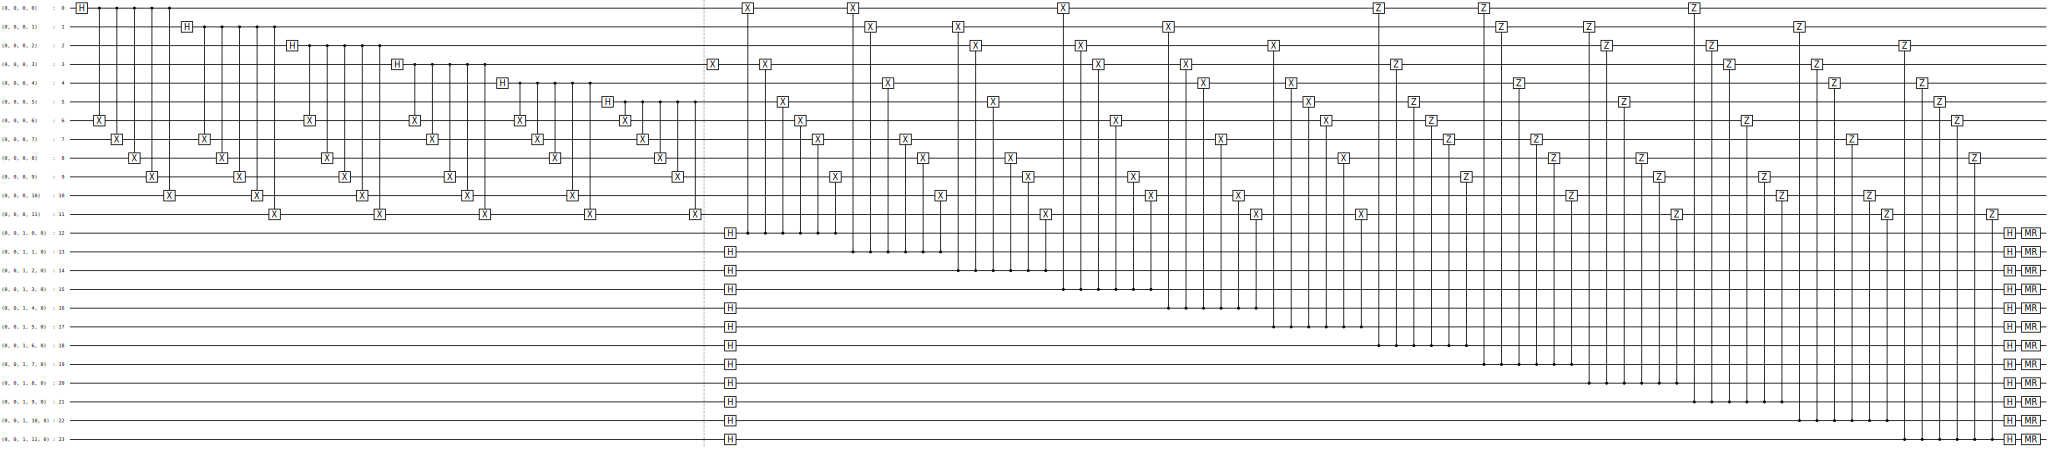

In [105]:
circ = cd.construct_encoding_circuit('non_ft')
circ.append('TICK')

# Step 2
#circ.append('Z', 2)
circ.append('X', 3)

# Step 3
cd.construct_syndrome_circuit()
circ += cd.syndrome_circuit

circ.draw()


In [106]:
circ = QuantumCircuit.from_qasm_str(circ.qasm())


In [112]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator, Aer
from qiskit_aer.primitives import EstimatorV2
from qiskit import transpile

In [113]:
def add_random_x_gate(circuit, p, n):
    """
    Randomly applies an X gate to each qubit in the quantum circuit with probability p.

    Parameters:
    - circuit (QuantumCircuit): The quantum circuit to modify.
    - p (float): The probability of applying an X gate to each qubit.
    """
    num_qubits = n
    log = []
    # For each qubit in the circuit, apply an X gate with probability p
    for qubit in range(num_qubits):
        if np.random.random() < p:  # With probability p, apply the X gate
            circuit.x(qubit)  # Apply X gate to the qubit
            log.append(qubit)
    return log

def add_random_z_gate(circuit, p, n):
    """
    Randomly applies an Z gate to each qubit in the quantum circuit with probability p.

    Parameters:
    - circuit (QuantumCircuit): The quantum circuit to modify.
    - p (float): The probability of applying an z gate to each qubit.
    """
    num_qubits = n
    log = []
    # For each qubit in the circuit, apply a z gate with probability p
    for qubit in range(num_qubits):
        if np.random.random() < p:  # With probability p, apply the z gate
            circuit.z(qubit)  # Apply z gate to the qubit
            log.append(qubit)

    return log

# Helper functions to parameterize above in terms of only qc.
def add_x(p, n):
    return lambda qc: add_random_x_gate(qc, p, n)

def add_z(p, n):
    return lambda qc: add_random_z_gate(qc, p, n)

In [114]:
# Transpile the circuit for the qasm simulator

qc = circ

simulator = Aer.get_backend('qasm_simulator')
transpiled_circuit = transpile(qc, backend=simulator)

# Simulate the circuit
job = simulator.run(transpiled_circuit, shots=1024)
result = job.result()
counts = result.get_counts()

# Display the measurement results
print("Measurement results:")
print(counts)

# # Calculate expectation values of stabilizers
# stabilizers = get_stabilizers(Hx, 'X') + get_stabilizers(Hz, 'Z')


# print("\nStabilizer operators:")
# print(stabilizers)

# # Expectation value calculation
# expectation_values = {}
# for stabilizer in stabilizers:
#     pauli_op = SparsePauliOp.from_list([(stabilizer, 1)])
#     exp_val = result.get_counts(qc)
#     expectation_values[stabilizer] = exp_val

# print("\nExpectation values:")
# for stabilizer, value in expectation_values.items():
#     print(f"{stabilizer}: {value}")

Measurement results:
{'011001000000 001110101011 011001000000000000000000': 8, '011001000000 110110100101 011001000000000000000000': 21, '011001000000 111011000000 011001000000000000000000': 15, '011001000000 000100111111 011001000000000000000000': 15, '011001000000 010100100000 011001000000000000000000': 16, '011001000000 101010100010 011001000000000000000000': 18, '011001000000 000011001110 011001000000000000000000': 13, '011001000000 001111010110 011001000000000000000000': 13, '011001000000 000010110011 011001000000000000000000': 10, '011001000000 001000100111 011001000000000000000000': 27, '011001000000 111101001100 011001000000000000000000': 17, '011001000000 111000000110 011001000000000000000000': 20, '011001000000 111100110001 011001000000000000000000': 13, '011001000000 111010111101 011001000000000000000000': 24, '011001000000 110111011000 011001000000000000000000': 9, '011001000000 110000101001 011001000000000000000000': 19, '011001000000 000101000010 011001000000000000000000'

In [115]:
# Since we only have one shot, get the measurement outcome
measurement_outcome = list(counts.keys())[0]

# Reverse the measurement outcome due to little-endian ordering
measurement_outcome = measurement_outcome[::-1]

# Extract data bits and syndrome bits
num_total_clbits = num_data_qubits + num_ancilla_qubits
data_bits = measurement_outcome[:num_data_qubits]
syndrome_bits = measurement_outcome[num_data_qubits:num_total_clbits]

# Split syndrome bits into X and Z syndromes
num_syndrome_bits_per_type = num_ancilla_qubits // 2
x_syndrome_bits = syndrome_bits[:num_syndrome_bits_per_type]
z_syndrome_bits = syndrome_bits[num_syndrome_bits_per_type:]

# Convert syndrome bits to NumPy arrays
x_syndrome = np.array([int(bit) for bit in x_syndrome_bits])
z_syndrome = np.array([int(bit) for bit in z_syndrome_bits])

In [ ]:
print(H0)

[[1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1.]]


In [ ]:
import ldpc.codes
from ldpc import BpOsdDecoder

In [118]:
bp_osd_z = BpOsdDecoder(
            Hx,
            error_rate = 0.05,
            bp_method = 'product_sum',
            max_iter = 15,
            schedule = 'serial',
            osd_method = 'osd_cs', #set to OSD_0 for fast solve
            osd_order = 2
        )

z_decoding = bp_osd_z.decode(z_syndrome)
print(f"Z Decoding: {z_decoding}")



Z Decoding: [0 0 0 1 0 0 0 0 0 0 0 0]


In [119]:
bp_osd_x = BpOsdDecoder(
            Hz,
            error_rate = 0.05,
            bp_method = 'product_sum',
            max_iter = 15,
            schedule = 'serial',
            osd_method = 'osd_cs', #set to OSD_0 for fast solve
            osd_order = 2
        )
        
x_decoding = bp_osd_x.decode(x_syndrome)
print(f"X Decoding: {x_decoding}")


X Decoding: [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bp_osd = BpOsdDecoder(
            H0,
            error_rate = 0.05,
            bp_method = 'product_sum',
            max_iter = 15,
            schedule = 'serial',
            osd_method = 'osd_cs', #set to OSD_0 for fast solve
            osd_order = 2
        )

int_list = [int(bit) for bit in list(counts.keys())[0]][:Hx.shape[1]][::-1]
# Create a NumPy array
syndrome = np.array(int_list)
#syndrome = np.array([0,0,0,0,0,0,0,1])

print(f"Syndrome: {syndrome}")
decoding = bp_osd.decode(syndrome)
print(f"Decoding: {decoding}")
decoding_syndrome = H0@decoding % 2

Syndrome: [0 0 0 0 0 0 1 0 0 1 1 0]
Decoding: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
